# Selección de portafolios usando simulación Montecarlo

<img style="float: right; margin: 0px 0px 15px 15px;" src="https://upload.wikimedia.org/wikipedia/commons/thumb/6/6e/Separation_theorem_of_MPT.svg/2000px-Separation_theorem_of_MPT.svg.png" width="400px" height="400px" />

> Durante el curso, específicamente en los módulos dos y tres, elaboramos toda la fundamentación de la teoría moderna de portafolios de Markowitz. Ésta se basa en la existencia de una línea especial en el espacio de rendimiento esperado vs. volatilidad, llamada **frontera de mínima varianza**.

> Al finalizar el módulo 3, vimos que no importa la cantidad de activos riesgosos que se tengan, si encontramos dos portafolios sobre la frontera eficiente, podemos reconstruirla. Dos portafolios importantes que hallamos en el curso fueron:

> - **Portafolio de mínima varianza**: minimizando la varianza.
> - **Portafolio eficiente en media varianza**: maximizando el radio de Sharpe.

> Por otra parte, resolver problemas de optimización cuando la cantidad de variables crece, se vuelve un problema complejo, computacionalmente hablando. Así que desarrollar métodos alternativos a la optimización que nos permitan encontrar los anteriores portafolios es de gran interés...

## 1. Descargamos activos de la BMV

Por simplicidad, y para entender las ideas alrededor de la selección de portafolios usando simulación montecarlo, utilizaremos únicamente tres activos de la BMV: America Movil SAB de CV L	(AMXL.MX), Walmart de Mexico SAB de CV	(WALMEX.MX) y Fomento Economico Mexicano S.A.B. de C.V.	(FEMSAUBD.MX).

1.1. Descargar precios mensuales ajustados en el cierre para los tres activos mencionados anteriormente en los últimos 5 años:

In [29]:
# Importar librerías
import pandas_datareader.data as web
from matplotlib import pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
%matplotlib inline

yf.pdr_override()

In [2]:
# Función para descargar precios de cierre ajustados:
def get_adj_closes(tickers,
                   start_date=None,
                   end_date=None,
                   interval="1d"
                  ):
    # Fecha inicio por defecto (start_date='2010-01-01') y fecha fin por defecto (end_date=today)
    # Descargamos DataFrame con todos los datos
    closes = web.get_data_yahoo(
        tickers=tickers,
        start=start_date,
        end=end_date,
        interval=interval
    )
    # Solo necesitamos los precios ajustados en el cierre
    closes = closes['Adj Close']
    # Se ordenan los índices de manera ascendente
    closes.sort_index(inplace=True)
    return closes

In [3]:
# Descargar precios y graficar
tickers = ["AMXL.MX", "WALMEX.MX", "FEMSAUBD.MX"]
start = "2018-04-01"

In [4]:
closes = get_adj_closes(
    tickers,
    start,
    interval="1mo"
)

[*********************100%***********************]  3 of 3 completed


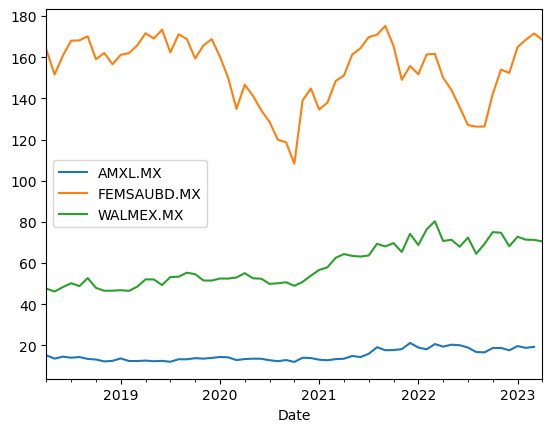

In [5]:
closes.plot();

1.2. A partir de los precios, obtener los rendimientos mensuales:

In [6]:
# Obtener rendimientos mensuales y graficar
ret = closes.pct_change().dropna()

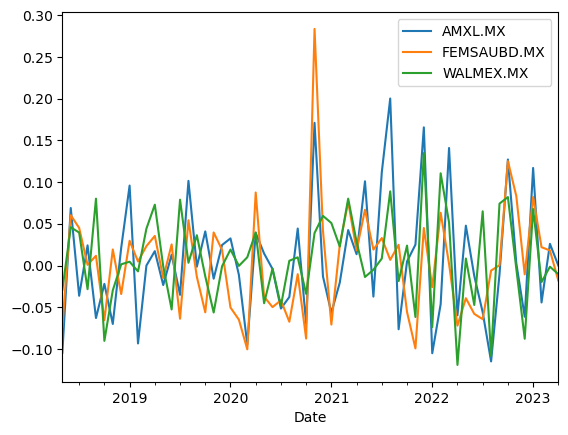

In [7]:
ret.plot();

1.3. Finalmente, a partir de los rendimientos mensuales, estimar la tendencia central de los rendimientos (rendimiento esperado), y caracterizar el riesgo de los activos (varianzas y covarianzas)

In [8]:
# Resumen: rendimiento medio mensual y volatilidad
summary = pd.DataFrame({
    "media": ret.mean(),
    "vol": ret.std()
})
summary

,media,vol
AMXL.MX,0.006482,0.072002
FEMSAUBD.MX,0.002395,0.063802
WALMEX.MX,0.008002,0.053709


In [10]:
# Matriz de covarianza
cov = ret.cov()
cov

,AMXL.MX,FEMSAUBD.MX,WALMEX.MX
AMXL.MX,0.005184,0.002395,0.001732
FEMSAUBD.MX,0.002395,0.004071,0.001277
WALMEX.MX,0.001732,0.001277,0.002885


In [11]:
# Matriz de correlación
corr = ret.corr()
corr

,AMXL.MX,FEMSAUBD.MX,WALMEX.MX
AMXL.MX,1.000000,0.521406,0.447945
FEMSAUBD.MX,0.521406,1.000000,0.372670
WALMEX.MX,0.447945,0.372670,1.000000


___
## 2. Selección de portafolios mediante montecarlo

Antes de continuar, consultamos la tasa libre de riesgo al día de hoy en [Banxico](http://www.banxico.org.mx/):

In [31]:
# Tasa libre de riesgo
rf = 0.1130 / 12
rf

0.009416666666666667

¿Alguien tiene alguna idea de lo que es simulación montecarlo?

En cuanto a la selección de portafolios, lo que hacemos es simular una gran cantidad de posibles portafolios que se pueden construir con los activos dados (generamos muchas ponderaciones posibles), y calculamos su rendimiento esperado y volatilidad para dibujarlos, y así poder identificar objetos de interés:

- frontera eficiente;
- portafolio de mínima varianza;
- portafolio EMV...

In [32]:
# Definimos el número de portafolios que simularemos, y la cantidad de activos que tenemos
n_activos = 3
n_portafolios = 100000

2.1. Generamos los portafolios

In [33]:
# Ayuda en la funcion numpy.random.dirichlet
help(np.random.dirichlet)

Help on built-in function dirichlet:

dirichlet(...) method of numpy.random.mtrand.RandomState instance
    dirichlet(alpha, size=None)
    
    Draw samples from the Dirichlet distribution.
    
    Draw `size` samples of dimension k from a Dirichlet distribution. A
    Dirichlet-distributed random variable can be seen as a multivariate
    generalization of a Beta distribution. The Dirichlet distribution
    is a conjugate prior of a multinomial distribution in Bayesian
    inference.
    
    .. note::
        New code should use the ``dirichlet`` method of a ``default_rng()``
        instance instead; please see the :ref:`random-quick-start`.
    
    Parameters
    ----------
    alpha : sequence of floats, length k
        Parameter of the distribution (length ``k`` for sample of
        length ``k``).
    size : int or tuple of ints, optional
        Output shape.  If the given shape is, e.g., ``(m, n)``, then
        ``m * n * k`` samples are drawn.  Default is None, in which c

In [34]:
(1,) * n_activos

(1, 1, 1)

In [35]:
# Generar una matriz de pesos de n_portafolios x n_activos,
# tal que cada fila sume uno (recordar restricción)
W = np.random.dirichlet(alpha=(1,) * n_activos, size=n_portafolios)

In [36]:
W

array([[0.24599965, 0.19558651, 0.55841383],
       [0.02493823, 0.61275078, 0.36231098],
       [0.25234378, 0.50970736, 0.23794885],
       ...,
       [0.32672251, 0.03695795, 0.63631954],
       [0.00675041, 0.37472115, 0.61852844],
       [0.40821503, 0.21212981, 0.37965516]])

In [37]:
W.shape

(100000, 3)

In [38]:
W.sum(axis=1)

array([1., 1., 1., ..., 1., 1., 1.])

In [39]:
# Rendimientos y volatilidad de cada portafolio
er_portafolios = W.dot(summary["media"])

In [40]:
er_portafolios

array([0.00653125, 0.00452824, 0.00476031, ..., 0.00729797, 0.00589054,
       0.00619189])

In [41]:
s_portafolios = np.zeros(n_portafolios)
for i in range(n_portafolios):
    w = W[i, :]
    s_portafolios[i] = (w.T.dot(cov).dot(w))**0.5

In [42]:
s_portafolios

array([0.0485214 , 0.05081138, 0.05181674, ..., 0.05064743, 0.04789545,
       0.05118928])

Las filas de la matriz $W$ representan vectores de pesos de los portafolios. Por ejemplo, la 51-ava fila de la matriz W:

```python
W[50, :]
```

representa el vector de pesos (ponderaciones) del 51-avo portafolio.

In [43]:
# Radio de Sharpe
rs = (er_portafolios - rf) / s_portafolios

In [60]:
# Data frame de resultados
portafolios = pd.DataFrame({
    "w": list(W.round(4)),
    "media": er_portafolios,
    "vol": s_portafolios,
    "rs": rs
})
portafolios.head()

,w,media,vol,rs
0,"[0.246, 0.1956, 0.5584]",0.006531,0.048521,-0.059467
1,"[0.0249, 0.6128, 0.3623]",0.004528,0.050811,-0.096207
2,"[0.2523, 0.5097, 0.2379]",0.004760,0.051817,-0.089862
3,"[0.174, 0.5638, 0.2622]",0.004576,0.051526,-0.093949
4,"[0.1291, 0.761, 0.1098]",0.003538,0.056677,-0.103715


In [63]:
rf

0.009416666666666667

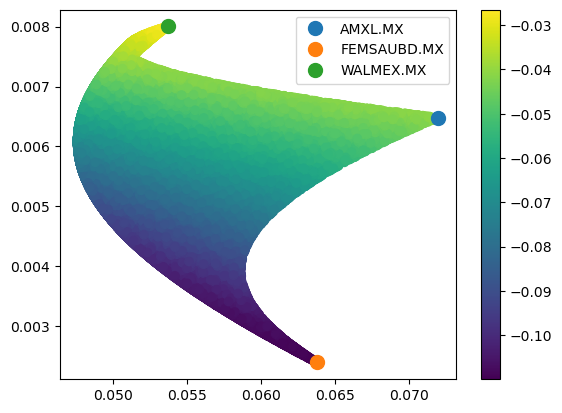

In [61]:
plt.scatter(
    portafolios["vol"],
    portafolios["media"],
    c=portafolios["rs"]
)
for i in range(len(summary)):
    plt.plot(
        summary.iloc[i]["vol"],
        summary.iloc[i]["media"],
        'o', ms=10,
        label=summary.index[i]
    )
plt.colorbar()
plt.legend()

2.2. Aproximar portafolio de mínima varianza y portafolio eficiente en media varianza

In [65]:
# Portafolio EMV
emv = portafolios.iloc[portafolios["rs"].idxmax()]
emv

w        [0.0002, 0.0012, 0.9986]
media                    0.007995
vol                      0.053669
rs                      -0.026492
Name: 60684, dtype: object

In [67]:
# Portafolio mínima varianza
minvar = portafolios.iloc[portafolios["vol"].idxmin()]
minvar

w        [0.0947, 0.318, 0.5873]
media                   0.006075
vol                     0.047614
rs                     -0.070187
Name: 60825, dtype: object

2.3. Dibujar todos los portafolios en el espacio de rendimiento esperado vs. volatilidad

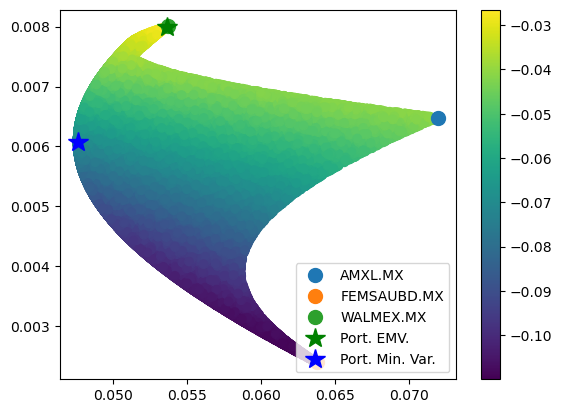

In [69]:
# Gráfica
plt.scatter(
    portafolios["vol"],
    portafolios["media"],
    c=portafolios["rs"]
)
for i in range(len(summary)):
    plt.plot(
        summary.iloc[i]["vol"],
        summary.iloc[i]["media"],
        'o', ms=10,
        label=summary.index[i]
    )
plt.plot(emv["vol"], emv["media"], "*g", ms=15, label="Port. EMV.")
plt.plot(minvar["vol"], minvar["media"], "*b", ms=15, label="Port. Min. Var.")
plt.colorbar()
plt.legend()

## 3. Comparar con los resultados obtenidos por optimización

3.1. Portafolio de mínima varianza

In [ ]:
# Importamos funcion minimize del modulo optimize de scipy


In [ ]:
## Construcción de parámetros
# 1. Sigma: matriz de varianza-covarianza

# 2. Eind: rendimientos esperados activos individuales


In [ ]:
# Función objetivo


In [ ]:
# Dato inicial

# Cotas de las variables

# Restricciones


In [ ]:
# Portafolio Min var


In [ ]:
# Comparar


In [ ]:
minvar

3.2. Portafolio EMV

In [ ]:
# Función objetivo


In [ ]:
# Dato inicial

# Cotas de las variables

# Restricciones


In [ ]:
# Portafolio EMV


In [ ]:
# Comparar


# Conclusión

- Tenemos una herramienta para aproximar toda la teoría de Markowitz.

- Esta herramienta no involucra optimización, solo generar números aleatorios en el símplex unitario.

- Por tanto, no le afecta el problema de dimensión (cuando tenemos muchos activos).

# Anuncios parroquiales

## 1. Fin de módulo. Abrir Clase0 y revisar objetivos del módulo.

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Esteban Jiménez Rodríguez.
</footer>